In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import copy


In [3]:
nodes = pd.read_csv('data/nodes.csv')
edging = pd.read_csv('data/edging.csv')



In [10]:
# clean up operator names, so they can be shown on the map

for i, node in nodes.iterrows():
    print(node['operator'])
    if pd.notnull(node['operator']):
        updated_operator = node['operator'].split(';')[0] 
        updated_operator = updated_operator.replace(' ', '_') 
        updated_operator = updated_operator.lower() 
        updated_operator = updated_operator.replace('\'', '') 
        nodes.at[i, 'operator'] = updated_operator
        
        
value_counts = nodes['operator'].value_counts()
nodes['operator_copy'] = copy.deepcopy(nodes['operator'])

nodes['operator'] = nodes['operator'].apply(lambda x: x if pd.notnull(x) and value_counts.get(x, 0) >= 3 else 'Other')

for i, edge in edging.iterrows():
    
    if pd.notnull(edge['operator']):
        updated_operator = edge['operator'].split(';')[0] 
        updated_operator = updated_operator.replace(' ', '_') 
        updated_operator = updated_operator.lower() 
        updated_operator = updated_operator.replace('\'', '') 
        edging.at[i, 'operator'] = updated_operator

edge_val_counts = edging['operator'].value_counts()
edging['operator'] = edging['operator'].apply(lambda x: x if pd.notnull(x) and edge_val_counts.get(x, 0) >= 1 else 'Other')


tennet
tennet
tennet
tennet_tso_gmbh
tennet
Other
tennet
50hertz
eon_netz
50hertz_transmission_gmbh
50hertz_transmission
50hertz_transmission_gmbh
tennet_tso_gmbh
tennet_tso_gmbh
tennet_tso_gmbh
eon_netz
50hertz
50hertz
tennet_tso_gmbh
50hertz_transmission
50hertz_transmission
50hertz_transmission
tennet
tennet
tennet
tennet
Other
tennet
tennet
Other
eon_netz
50hertz_transmission_gmbh
50hertz
tennet
tennet
tennet
50hertz_transmission_gmbh
50hertz_transmission
50hertz_transmission_gmbh
50hertz_transmission_gmbh
50hertz
50hertz
50hertz_transmission_gmbh
50hertz
50hertz_transmission_gmbh
50hertz
Other
Other
tennet_tso_gmbh
e.on_kraftwerke_gmbh
tennet
enbw
enbw
Other
Other
enbw
Other
enbw
tennet
eon_netz
Other
Other
enbw
Other
Other
tennet
Other
rwe
rwe
rwe
50hertz
50hertz
50hertz
50hertz
50hertz
tennet
eon_netz
50hertz_transmission_gmbh
50hertz_transmission
50hertz
50hertz
eon_netz
eon_netz
e.on_kraftwerke_gmbh
rwe
amprion
rwe
rwe
rwe
rwe
Other
Other
tennet
amprion
amprion
Other
Other
50h

In [5]:
nodes.head()

,Unnamed: 0,v_id,lon,lat,typ,voltage,frequency,name,operator,ref,operator_copy
0,0,1,9.522576,52.360409,substation,220000;110000,50,Hannover/West,tennet,NaN,tennet
1,1,2,9.113210,52.543853,substation,220000,50,Umspannwerk Kraftwerk Robert Frank,tennet,NaN,tennet
2,2,3,9.389745,52.026313,substation,380000;110000,50,UW Grohnde 380 kV / 110 kV,tennet,NaN,tennet
3,3,4,9.125266,52.538264,substation,380000;220000,50,Landesbergen,tennet_tso_gmbh,NaN,tennet_tso_gmbh
4,4,5,10.366275,52.284647,substation,380000;220000,50,Wahle,tennet,NaN,tennet


In [6]:
nodes['operator_copy'].value_counts()

operator_copy
amprion                     79
tennet                      55
rwe                         47
50hertz                     35
enbw                        23
                            ..
vse                          1
enbw_transportnetze_ag       1
vorarlberger_illwerke_ag     1
vattenfall_europe            1
bayernwerk_ag                1
Name: count, Length: 73, dtype: int64

In [8]:
nodes.head()

,Unnamed: 0,v_id,lon,lat,typ,voltage,frequency,name,operator,ref,operator_copy
0,0,1,9.522576,52.360409,substation,220000;110000,50,Hannover/West,tennet,NaN,tennet
1,1,2,9.113210,52.543853,substation,220000,50,Umspannwerk Kraftwerk Robert Frank,tennet,NaN,tennet
2,2,3,9.389745,52.026313,substation,380000;110000,50,UW Grohnde 380 kV / 110 kV,tennet,NaN,tennet
3,3,4,9.125266,52.538264,substation,380000;220000,50,Landesbergen,tennet_tso_gmbh,NaN,tennet_tso_gmbh
4,4,5,10.366275,52.284647,substation,380000;220000,50,Wahle,tennet,NaN,tennet


In [9]:
edging['operator'].value_counts()

operator
Amprion                   301
50Hertz                   112
TenneT                    105
50Hertz Transmission       26
EnBW                       14
transpower                  6
50Hertz_Transmission        4
amprion                     4
Amprion;TenneT              4
Schluchseewerk AG           2
Energinet.dk;TenneT         2
markE                       2
Stadtwerke München          2
TenneT TSO GmbH             2
PSE Operator;50Hertz        1
ČEPS                        1
EnBW Transportnetze AG      1
CEPS;TenneT TSO GmbH        1
PSE-O;50Hertz               1
RWE                         1
Stromnetz Berlin            1
Transnet BW GmbH            1
LEW                         1
Netz Veltheim               1
50hertz                     1
RTE                         1
Name: count, dtype: int64

In [14]:

G = nx.Graph()

for i, row in nodes.iterrows():
    G.add_node(row['v_id'], name = row['name'], lon = row['lon'], lat = row['lat'], type = row['typ'], operator = row['operator'])
    
    
for i, row in edging.iterrows():
    G.add_edge(row['v_id_1'], row['v_id_2'], length = row['length_m'], voltage = row['voltage'], cables = row['cables'], wires = row['wires'], name = row['name'], operator = row['operator'])
    


In [15]:
#nx.write_gexf(G, 'data/power.gexf')

In [27]:
import matplotlib.colors as mcolors
def draw_germany_map(G, color_key='type', edges_color_key=None, node_labels=False):
    node_positions = {node: (data['lon'], data['lat']) for node, data in G.nodes(data=True)}
    
    fig, ax = plt.subplots(figsize=(20, 20))
    m = Basemap(projection='merc', 
                llcrnrlat=46, urcrnrlat=57, 
                llcrnrlon=5, urcrnrlon=16, 
                resolution='i')
    
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='white', lake_color='aqua')
    
    node_types = {node: data[color_key] for node, data in G.nodes(data=True)}
    unique_types = set(node_types.values())
    
    colors = plt.cm.tab20.colors 
    color_list = list(mcolors.CSS4_COLORS.keys()) 
    color_palette = colors if len(unique_types) <= len(colors) else color_list
    
    colormap = {node_type: color_palette[i % len(color_palette)] for i, node_type in enumerate(unique_types)}
    
    node_colors = [colormap[node_types[node]] for node in G.nodes]
    
    if edges_color_key:
        edge_types = {(u,v): data[edges_color_key] for u, v, data in G.edges(data=True)}
        unique_edge_types = set(edge_types.values())
        edges_colormap = colors if len(unique_edge_types) <= len(colors) else color_list
        edge_colormap = {edge_type: edges_colormap[i % len(edges_colormap)] for i, edge_type in enumerate(unique_edge_types)}
        edge_colors = [edge_colormap[edge_types[(u, v)]] for u, v in G.edges]
    else:
        edge_colors = ['blue'] * len(G.edges)
    
    mapped_positions = {node: m(lon, lat) for node, (lon, lat) in node_positions.items()}
    for (u, v), color in zip(G.edges, edge_colors):
        x = [mapped_positions[u][0], mapped_positions[v][0]]
        y = [mapped_positions[u][1], mapped_positions[v][1]]
        plt.plot(x, y, color=color, linewidth=2, alpha=0.7)

    x, y = zip(*mapped_positions.values())
    plt.scatter(x, y, c=node_colors, s=30, zorder=5)
    
    if node_labels:
        for node, (lon, lat) in node_positions.items():
            x, y = m(lon, lat)
            plt.text(x, y, str(node), fontsize=6, ha='right')
        
    
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=node_type, 
                          markerfacecolor=color, markersize=10) 
               for node_type, color in colormap.items()]
    plt.legend(handles=handles, loc='lower right')
    
    if edges_color_key:
        edge_handles = [plt.Line2D([0], [0], color=color, lw=2, label=edge_type) 
                        for edge_type, color in edge_colormap.items()]
        plt.legend(handles=edge_handles, loc='upper right', title='Edge Types')
    
    plt.title("Network Graph Overlaid on Germany Map")
    plt.show()

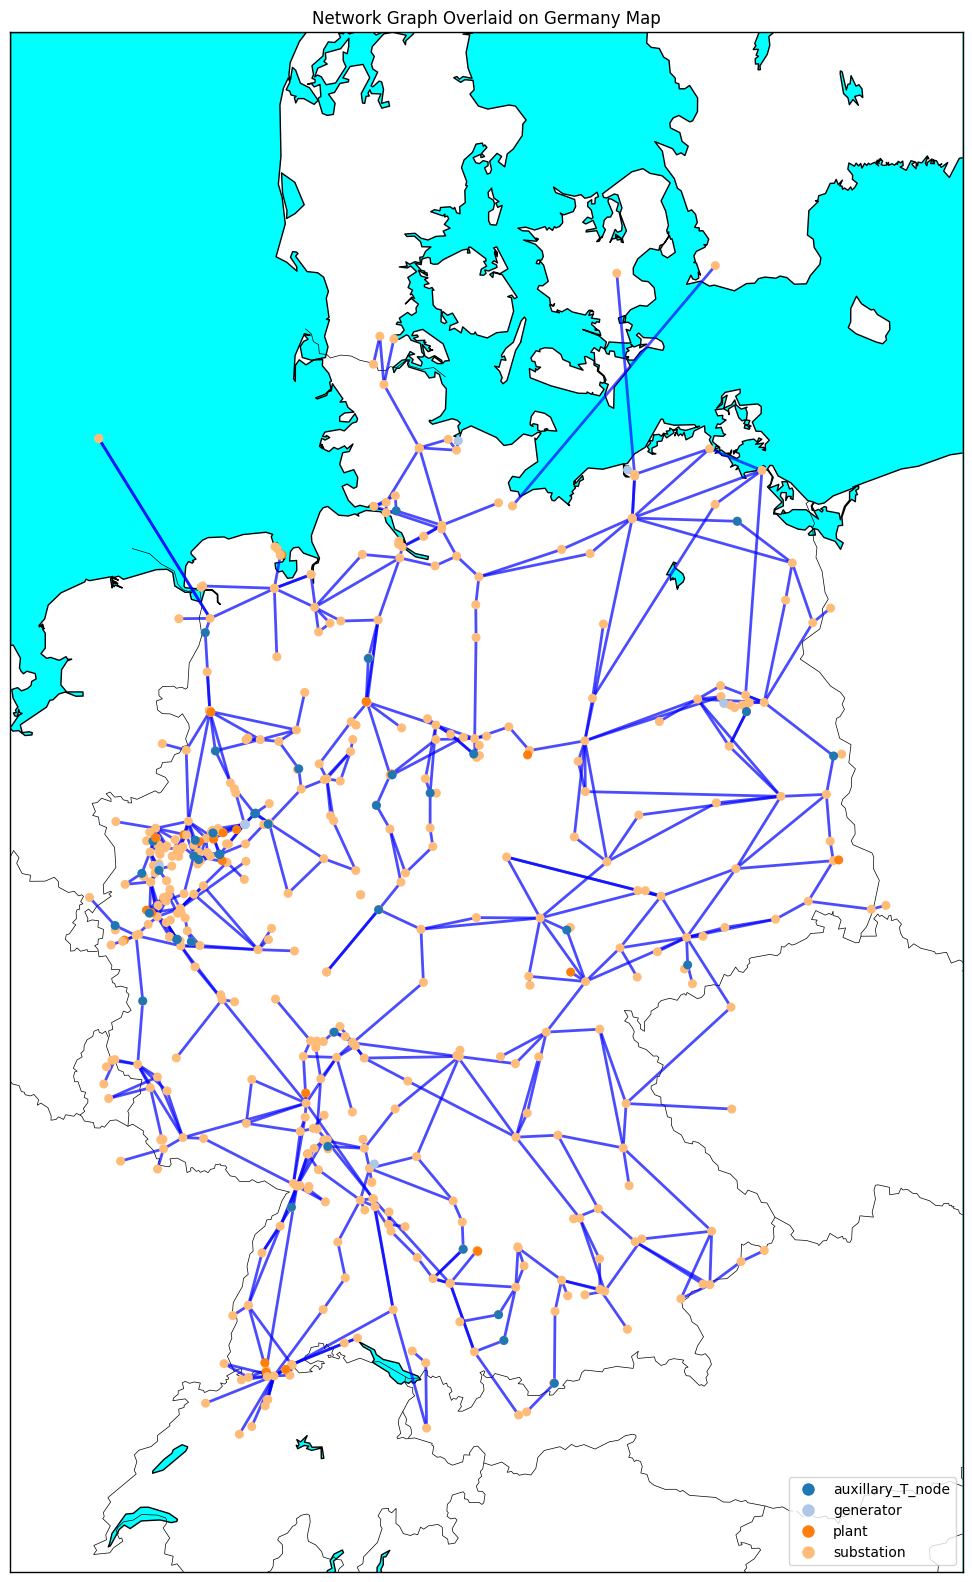

In [28]:
draw_germany_map(G)

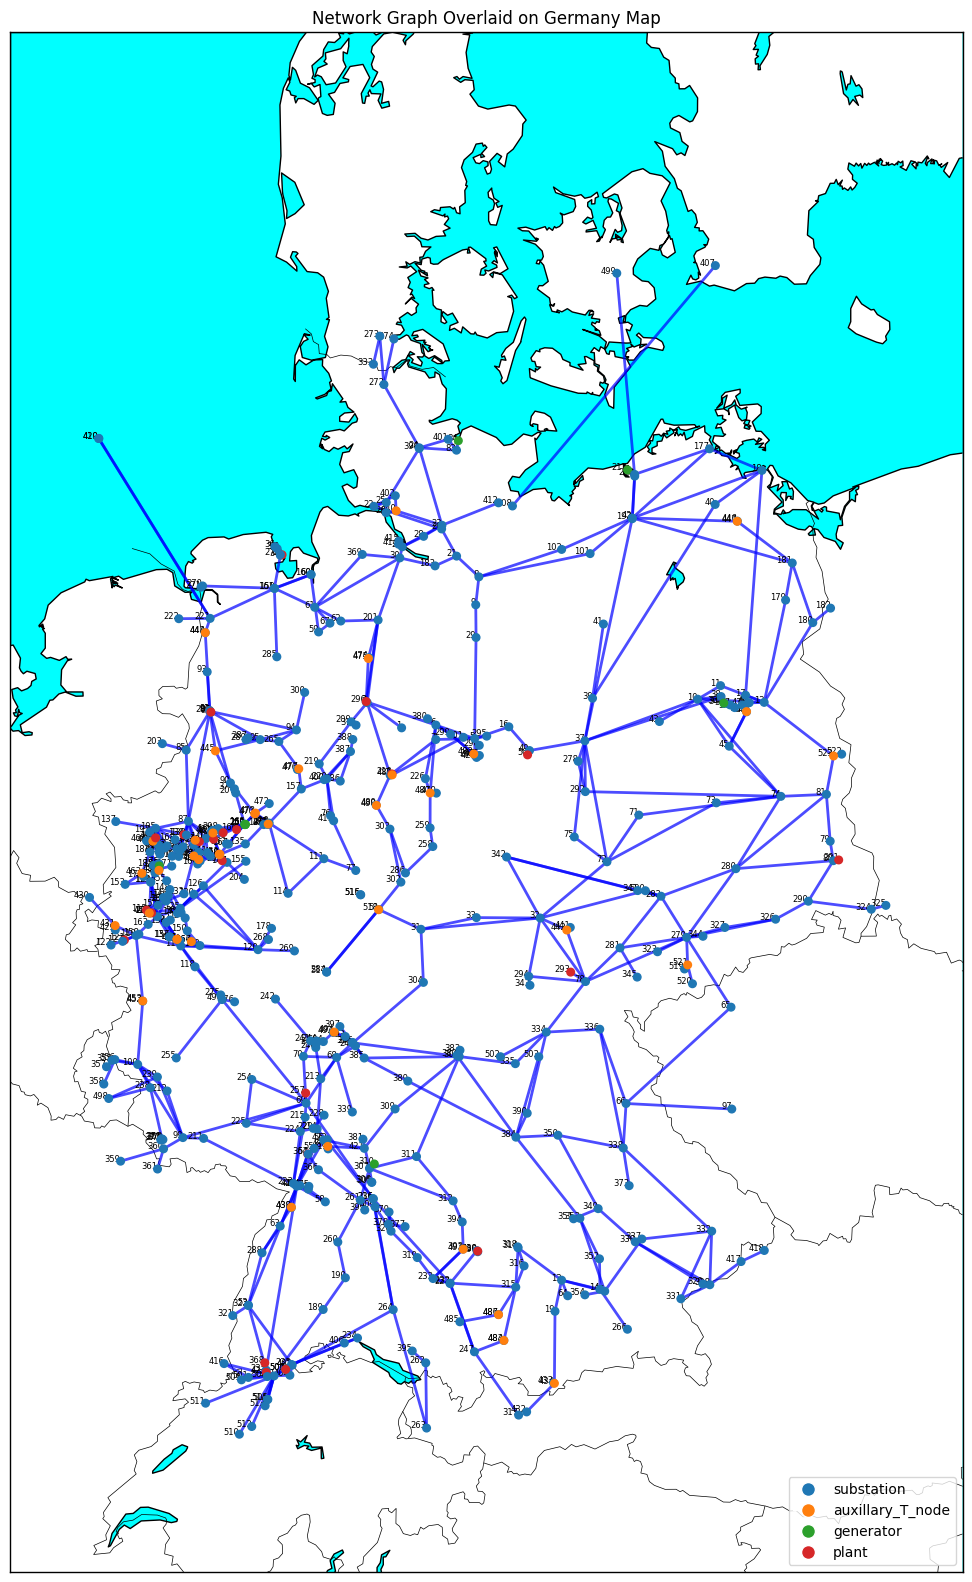

In [24]:
draw_germany_map(G, 'type')

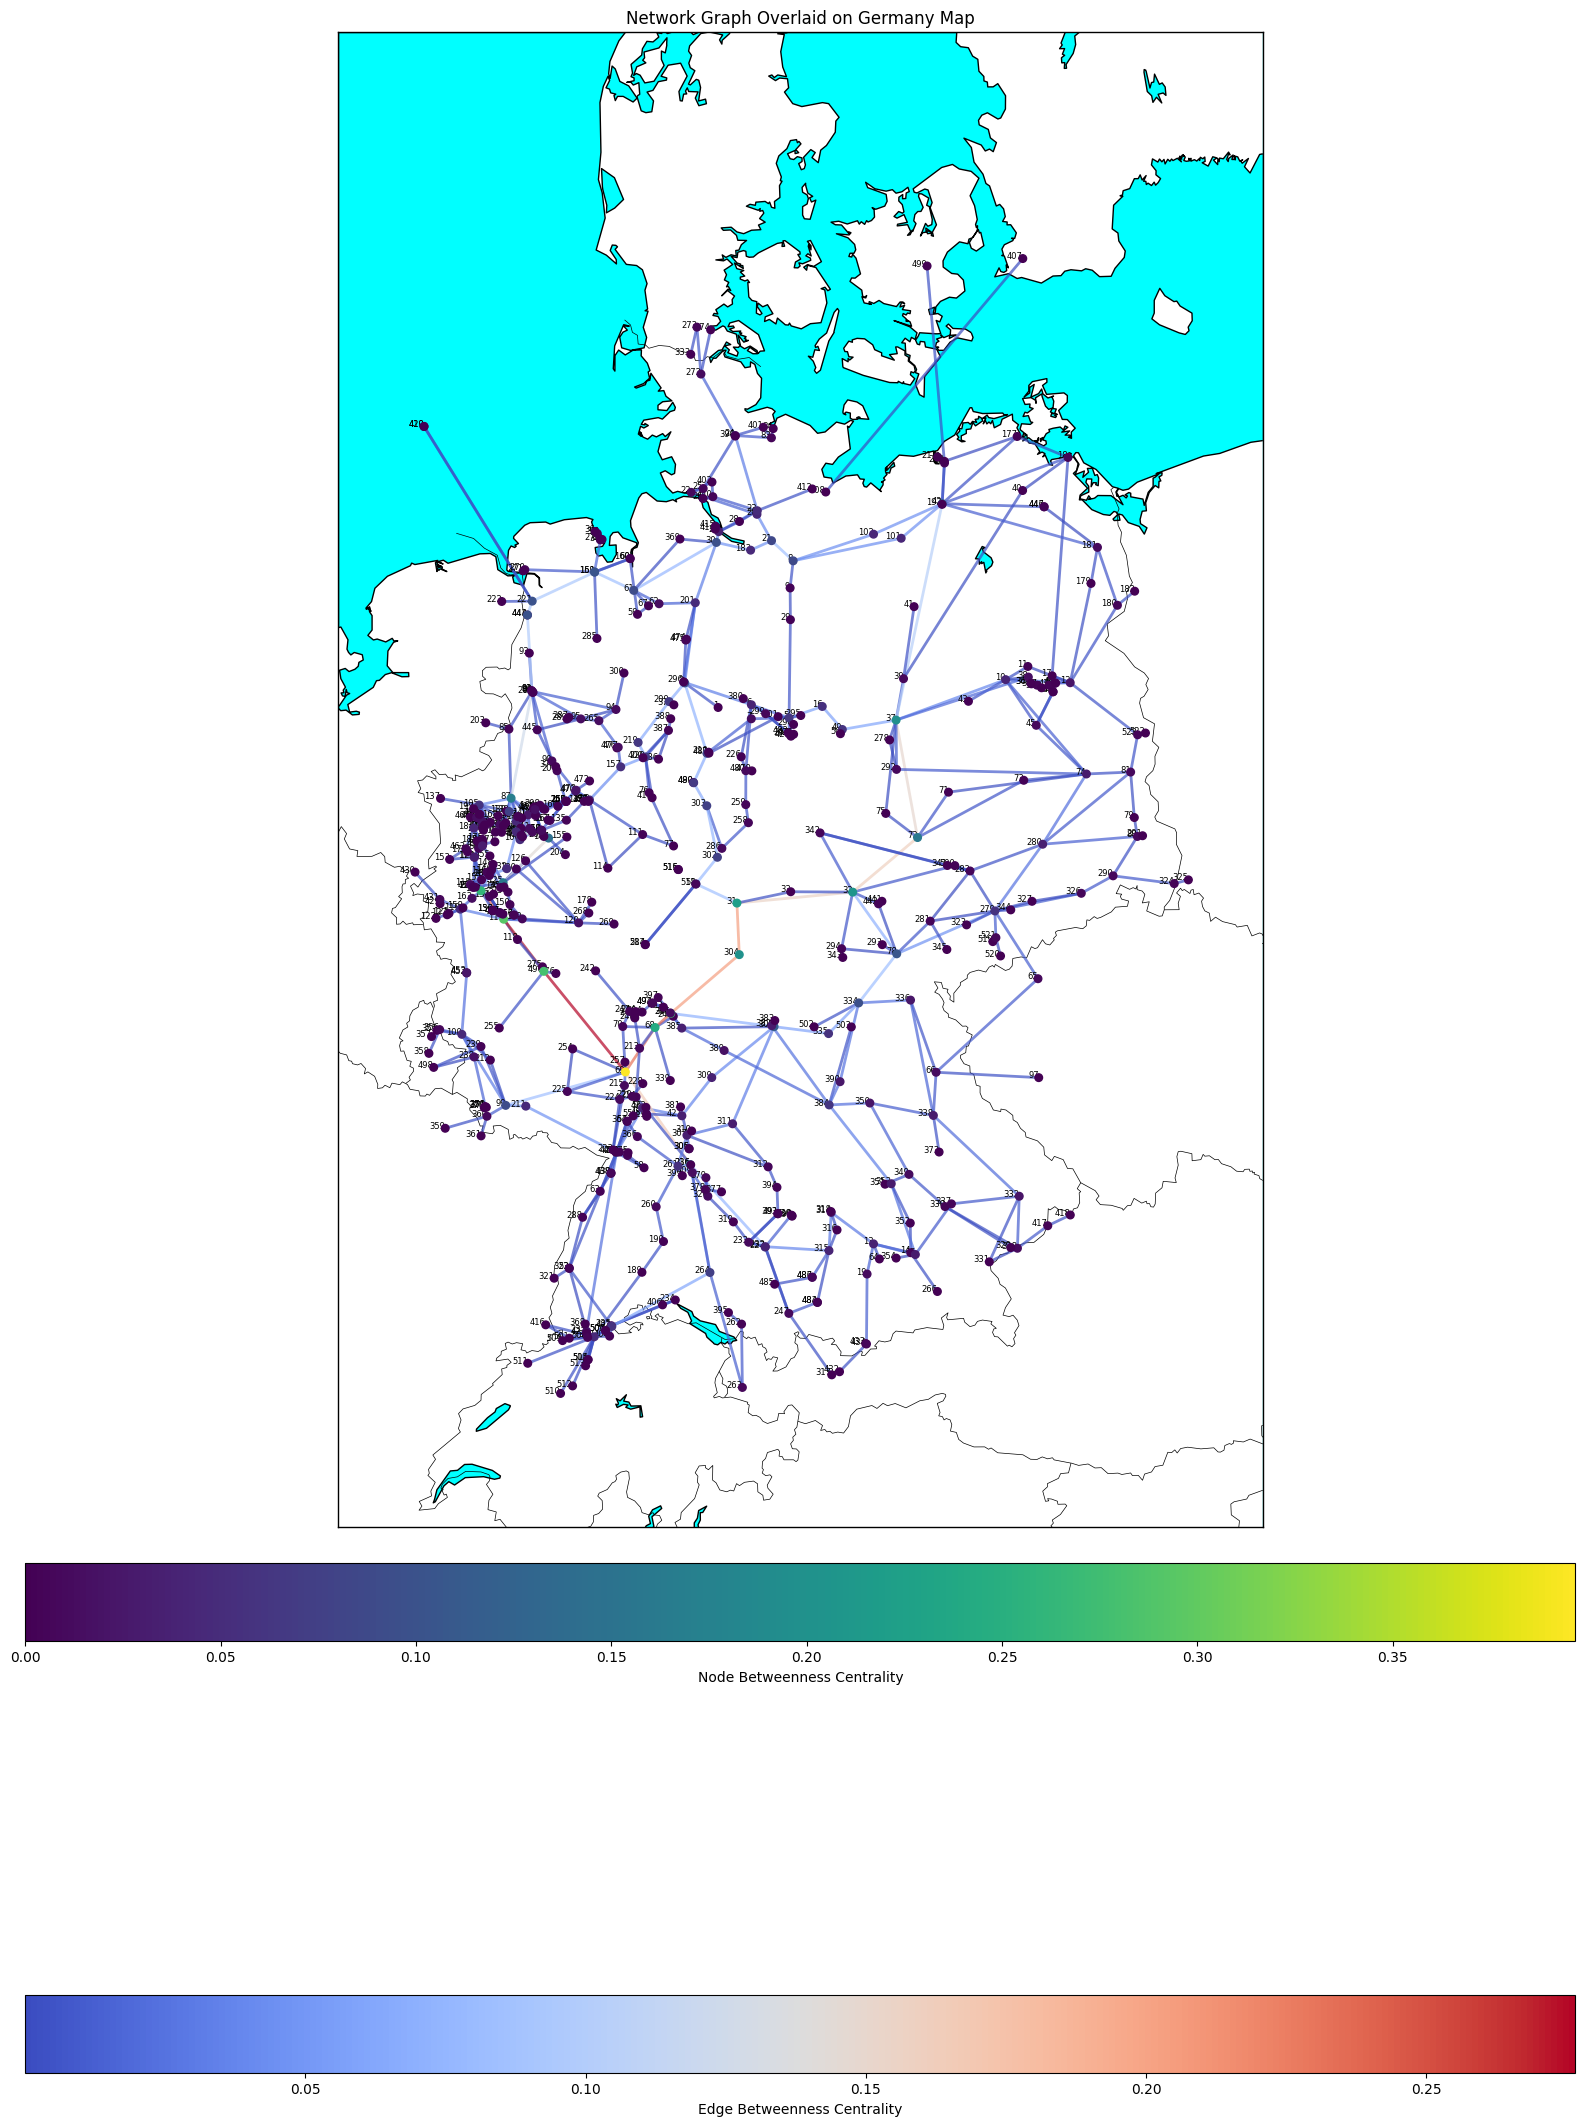

In [30]:
node_positions = {node: (data['lon'], data['lat']) for node, data in G.nodes(data=True)}


node_betweenness = nx.betweenness_centrality(G, normalized=True)

max_node_centrality = max(node_betweenness.values())
min_node_centrality = min(node_betweenness.values())
node_colors = [
    (node_betweenness[node] - min_node_centrality) / (max_node_centrality - min_node_centrality)
    for node in G.nodes
]

fig, ax = plt.subplots(figsize=(20, 30))
m = Basemap(projection='merc', 
            llcrnrlat=46, urcrnrlat=57, 
            llcrnrlon=5, urcrnrlon=16, 
            resolution='i')

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='white', lake_color='aqua')

mapped_positions = {node: m(lon, lat) for node, (lon, lat) in node_positions.items()}
node_types = {node: data['type'] for node, data in G.nodes(data=True)}
colormap = {'substation':'blue', 'auxillary_T_node':'orange', 'plant':'red', 'generator':'purple'}
#node_colors = [colormap[node_types[node]] for node in G.nodes]

edge_betweenness = nx.edge_betweenness_centrality(G, normalized=True)

max_edge_centrality = max(edge_betweenness.values())
min_edge_centrality = min(edge_betweenness.values())
edge_colors = [
    (edge_betweenness[(u, v)] - min_edge_centrality) / (max_edge_centrality - min_edge_centrality)
    for u, v in G.edges
]

for (u, v), color in zip(G.edges, edge_colors):
    x = [mapped_positions[u][0], mapped_positions[v][0]]
    y = [mapped_positions[u][1], mapped_positions[v][1]]
    plt.plot(x, y, color=plt.cm.coolwarm(color), linewidth=2, alpha=0.7)

x, y = zip(*mapped_positions.values())
plt.scatter(x, y, c=node_colors, s=30, zorder=5)

for node, (lon, lat) in node_positions.items():
    x, y = m(lon, lat)
    plt.text(x, y, str(node), fontsize=6, ha='right')
    
edge_norm = plt.Normalize(vmin=min_edge_centrality, vmax=max_edge_centrality)
sm_edge = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=edge_norm)
sm_edge.set_array([])  
cbar_edge = fig.colorbar(sm_edge, ax=ax, orientation="horizontal", pad=0.07)
cbar_edge.set_label("Edge Betweenness Centrality")

node_norm = plt.Normalize(vmin=min_node_centrality, vmax=max_node_centrality)
sm_node = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=node_norm)
sm_node.set_array([])  
cbar_node = fig.colorbar(sm_node, ax=ax, orientation="horizontal", pad=0.02)
cbar_node.set_label("Node Betweenness Centrality")

plt.title("Network Graph Overlaid on Germany Map")
plt.show()

In [49]:
import random

def evaluate_network_robustness_edges(graph, num_trials=100):
    edges = list(graph.edges)

    fractions_removed = np.zeros(len(edges))
    fractions_outside_lcc = np.zeros(len(edges))
        
    
    for _ in range(num_trials):
        
        
        edges = list(graph.edges)
        random.shuffle(edges)
        
        num_edges = len(edges)
        num_nodes = len(graph.nodes)
        
        G_copy = graph.copy()
        
        for i, edge in enumerate(edges):
            G_copy.remove_edge(*edge)
            
            largest_cc = max(nx.connected_components(G_copy), key=len)
            size_lcc = len(largest_cc)
            
            fraction_outside = (num_nodes - size_lcc) / num_nodes
            
            fraction_removed = (i + 1) / num_edges
            
            fractions_removed[i] = np.average([fraction_removed, fractions_removed[i]])
            fractions_outside_lcc[i] = np.average([fraction_outside, fractions_outside_lcc[i]])
    
    
    G_copy = graph.copy()
    
    num_edges = len(edges)
    fractions_removed_cent = np.zeros(len(edges))
    fractions_outside_lcc_cent = np.zeros(len(edges))
    for i in range(num_edges):  
        edge_betweenness = nx.edge_betweenness_centrality(G_copy, normalized=True)
    
        sorted_edges_cents = sorted(edge_betweenness.items(), key=lambda item:item[1], reverse=True)
        sorted_edges = [edge for edge, cent in sorted_edges_cents]
        edge_to_remove = sorted_edges[0]
        G_copy.remove_edge(*edge_to_remove)

        largest_cc = max(nx.connected_components(G_copy), key=len)
        size_lcc = len(largest_cc)

        fraction_outside = (num_nodes - size_lcc) / num_nodes

        fraction_removed = (i + 1) / num_edges

        fractions_removed_cent[i] = fraction_removed
        fractions_outside_lcc_cent[i] = fraction_outside


            
    plt.figure(figsize=(10, 6))
    plt.plot(fractions_removed, fractions_outside_lcc, marker='o', linestyle='-', color='b', label="random removal")
    plt.plot(fractions_removed_cent, fractions_outside_lcc_cent, marker='o', linestyle='-', color='r', label="removal with highest edge betweenness centrality")
    plt.title("Network Robustness Analysis")
    plt.xlabel("Fraction of Edges Removed")
    plt.ylabel("Fraction of Nodes Outside LCC")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return

def evaluate_network_robustness_nodes(graph, num_trials=100):
    nodes = list(graph.nodes)

    fractions_removed_rand = np.zeros(len(nodes))
    fractions_outside_lcc_rand = np.zeros(len(nodes))
        
    
    for _ in range(num_trials):
        
        
        nodes = list(graph.nodes)
        random.shuffle(nodes)
        
        num_nodes = len(graph.nodes)
        
        G_copy = graph.copy()
        
        for i, node in enumerate(nodes):
            G_copy.remove_node(node)
            
            if len(G_copy.nodes) > 0:
                largest_cc = max(nx.connected_components(G_copy), key=len)
            else:
                largest_cc = set()
            size_lcc = len(largest_cc)
            
            fraction_outside = (num_nodes - size_lcc) / num_nodes
            fraction_removed = (i + 1) / num_nodes
            
            fractions_removed_rand[i] = np.average([fraction_removed, fractions_removed_rand[i]])
            fractions_outside_lcc_rand[i] = np.average([fraction_outside, fractions_outside_lcc_rand[i]])
            
    nodes = list(graph.nodes)
    degree_dict = dict(graph.degree(nodes))
    sorted_nodes = sorted(degree_dict, key=lambda node : degree_dict[node], reverse=True)

    fractions_removed_deg = np.zeros(len(nodes))
    fractions_outside_lcc_deg = np.zeros(len(nodes))
    
    num_nodes = len(sorted_nodes)

    G_copy = graph.copy()
    
    for i, node in enumerate(sorted_nodes):
        G_copy.remove_node(node)
        
        if len(G_copy.nodes) > 0:
            largest_cc = max(nx.connected_components(G_copy), key=len)
        else:
            largest_cc = set()
        size_lcc = len(largest_cc)
        
        fraction_removed = (i + 1) / num_nodes
        fraction_outside = (num_nodes - size_lcc) / num_nodes
        
        fractions_removed_deg[i] = fraction_removed
        fractions_outside_lcc_deg[i] = fraction_outside
    
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(fractions_removed_rand, fractions_outside_lcc_rand, marker='o', linestyle='-', color='b', label="random removal")
    plt.plot(fractions_removed_deg, fractions_outside_lcc_deg, marker='o', linestyle='-', color='r', label="high degree removal")
    plt.title("Network Robustness Analysis")
    plt.xlabel("Fraction of Edges Removed")
    plt.ylabel("Fraction of Nodes Outside LCC")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return

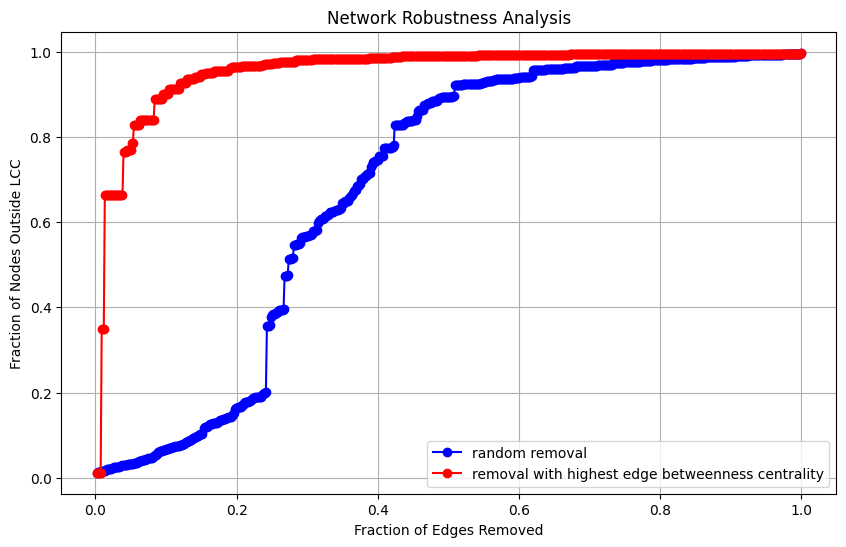

In [50]:
evaluate_network_robustness_edges(G, num_trials=500)

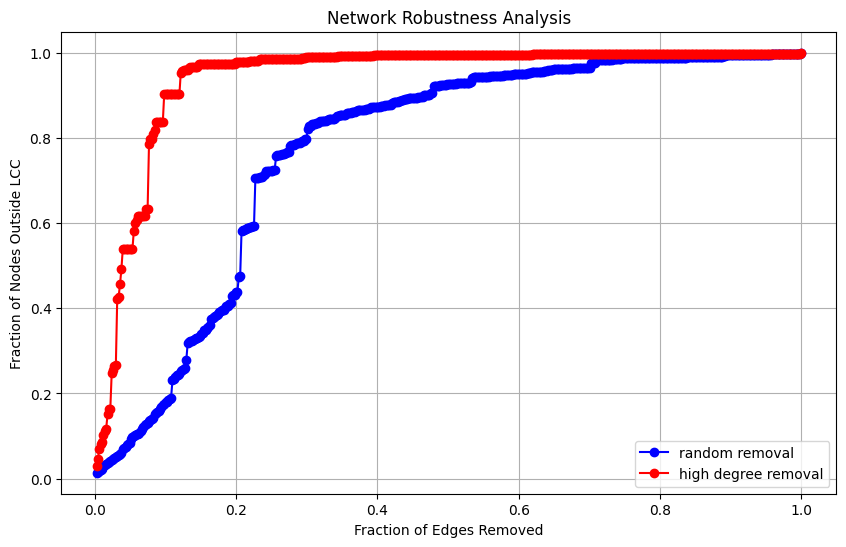

In [42]:
evaluate_network_robustness_nodes(G, num_trials=500)

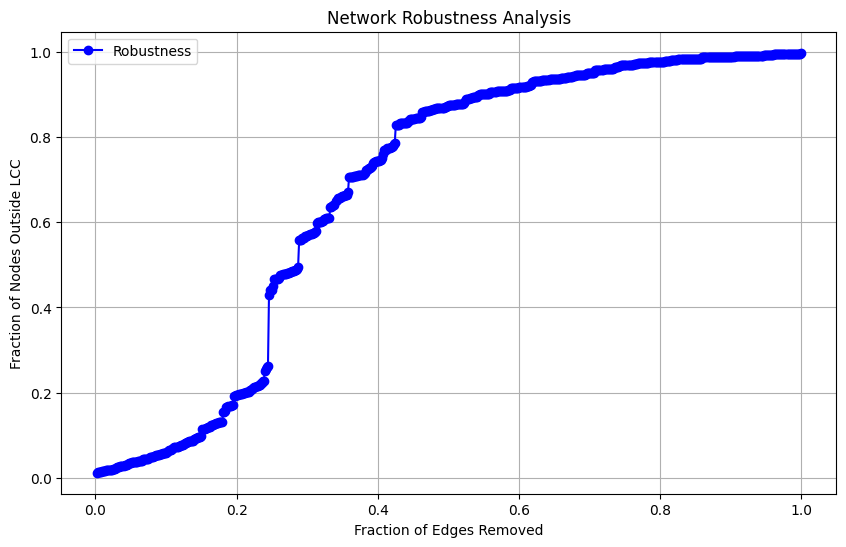

In [28]:
fractions_removed, fractions_outside_lcc = evaluate_network_robustness_edges(G, num_trials=500)

plt.figure(figsize=(10, 6))
plt.plot(fractions_removed, fractions_outside_lcc, marker='o', linestyle='-', color='b', label="Robustness")
plt.title("Network Robustness Analysis")
plt.xlabel("Fraction of Edges Removed")
plt.ylabel("Fraction of Nodes Outside LCC")
plt.grid(True)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Network Graph colored by communities')

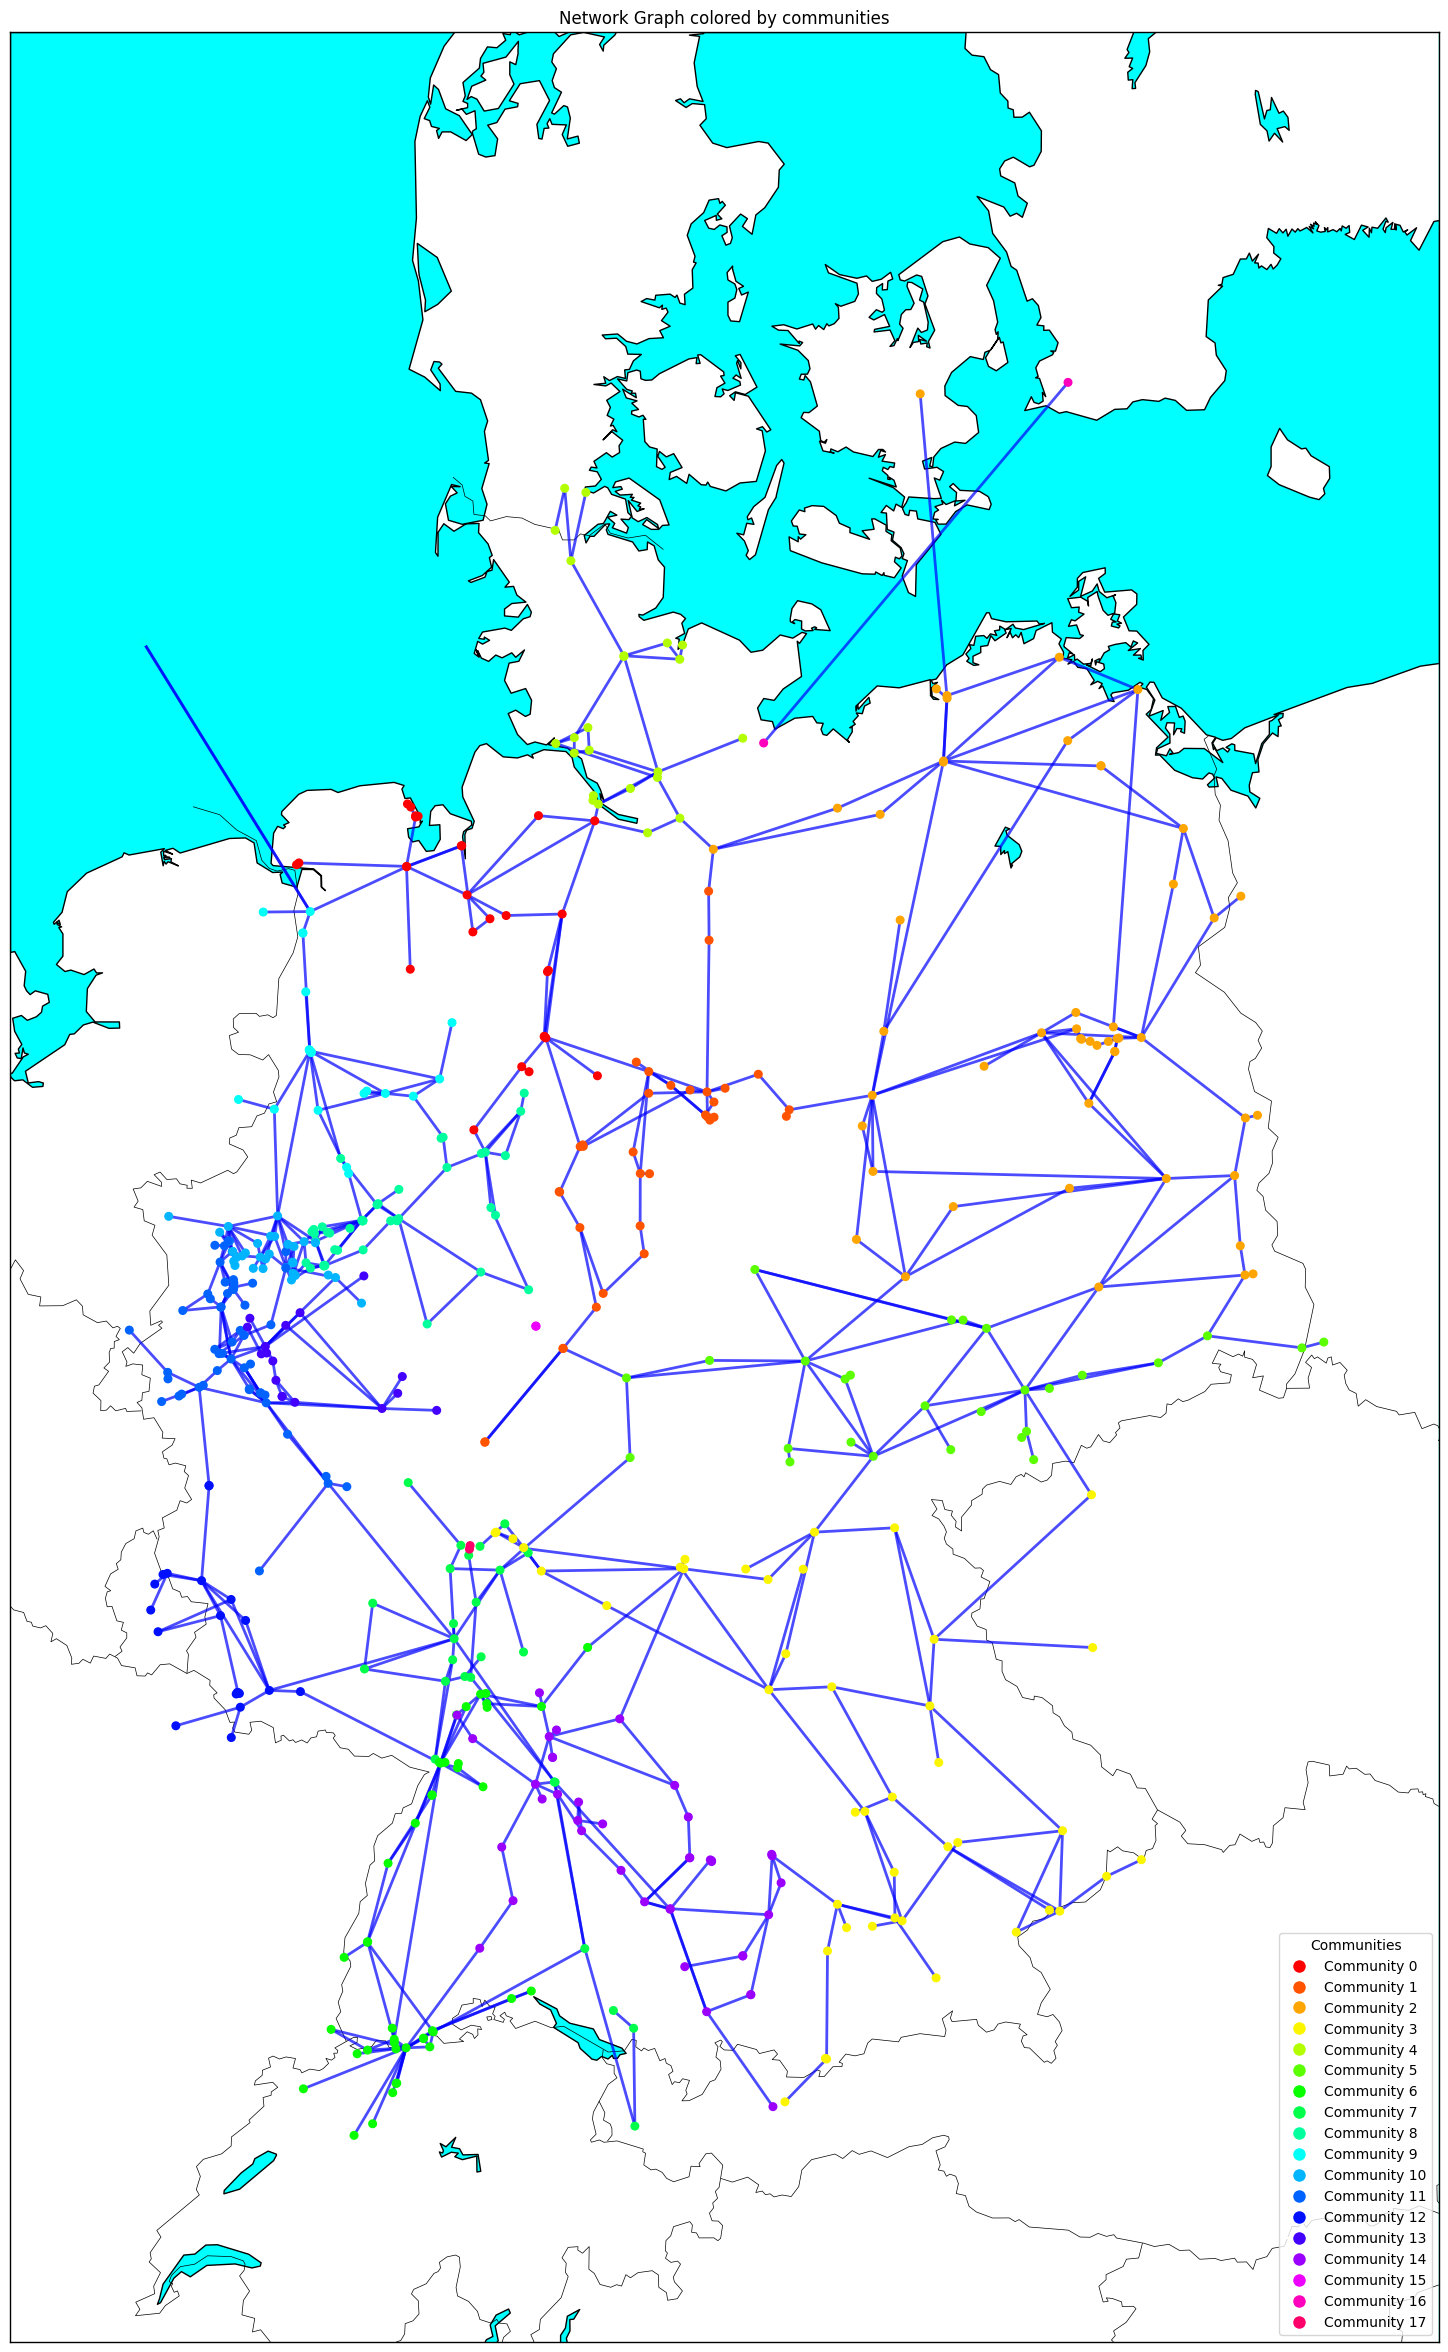

In [51]:
import community.community_louvain as community_louvain

partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, partition, "community")

communities = set(partition.values())
colors = plt.cm.hsv([i / len(communities) for i in range(len(communities))])
community_colors = {community: color for community, color in zip(communities, colors)}

fig, ax = plt.subplots(figsize=(20, 30))
m = Basemap(projection='merc', 
            llcrnrlat=46, urcrnrlat=57, 
            llcrnrlon=5, urcrnrlon=16, 
            resolution='i')

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='white', lake_color='aqua')

mapped_positions = {node: m(lon, lat) for node, (lon, lat) in node_positions.items()}

for u, v in G.edges:
    x = [mapped_positions[u][0], mapped_positions[v][0]]
    y = [mapped_positions[u][1], mapped_positions[v][1]]
    plt.plot(x, y, color="Blue", linewidth=2, alpha=0.7)

node_colors = [community_colors[partition[node]] for node in G.nodes]
x, y = zip(*mapped_positions.values())
plt.scatter(x, y, c=node_colors, s=30, zorder=5)

legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=f"Community {community}",
               markerfacecolor=color, markersize=10)
    for community, color in community_colors.items()
]
plt.legend(handles=legend_handles, title="Communities", loc='lower right', fontsize=10)


plt.title("Network Graph colored by communities")

In [60]:

from collections import defaultdict

community_dict = {node: data['community'] for node, data in G.nodes(data=True)}

outgoing_connections = defaultdict(int)

for u, v in G.edges():
    community_u = community_dict[u]
    community_v = community_dict[v]
    if community_u != community_v: 
        outgoing_connections[community_u] += 1

print("Outgoing connections from each community:")
for community, count in outgoing_connections.items():
    print(f"Community {community}: {count} outgoing connections")

Outgoing connections from each community:
Community 0: 4 outgoing connections
Community 1: 1 outgoing connections
Community 2: 6 outgoing connections
Community 4: 4 outgoing connections
Community 5: 1 outgoing connections
Community 6: 3 outgoing connections
Community 7: 2 outgoing connections
Community 8: 7 outgoing connections
Community 10: 4 outgoing connections
Community 11: 8 outgoing connections
Community 12: 3 outgoing connections
Community 14: 6 outgoing connections
Community 9: 1 outgoing connections
Community 15: 2 outgoing connections


In [57]:
def net_att_val_counts(G, attribute):
    attribute_values = [data[attribute] for _, data in G.nodes(data=True)]
    value_counts = Counter(attribute_values)
    return value_counts

In [58]:

net_att_val_counts(G, 'community')

Counter({0: 28,
         1: 34,
         2: 44,
         4: 45,
         5: 23,
         6: 34,
         7: 45,
         8: 22,
         9: 44,
         10: 23,
         11: 36,
         12: 19,
         13: 29,
         14: 38,
         15: 41,
         16: 2,
         17: 2,
         3: 2})

In [47]:
from collections import Counter
gen = 'generator'
plant = 'plant'

target_nodes = [node for node, data in G.nodes(data=True) if data['type'] == gen or data['type'] == plant]


path_lengths = {node: float('inf') for node in G.nodes}

for target in target_nodes:
    length_to_target = nx.single_source_shortest_path_length(G, target)

    for node, length in length_to_target.items():
        path_lengths[node] = min(path_lengths[node], length)
    
power_path = "path_to_gen_plant"
        
nx.set_node_attributes(G, path_lengths, name=power_path)

for node in target_nodes:
    G.nodes[node]['path_to_gen_plant'] = 0
    

attribute_values = [data[power_path] for _, data in G.nodes(data=True) if power_path in data]

value_counts = Counter(attribute_values)

print("Value counts for attribute:", power_path)
for value, count in value_counts.items():
    print(f"{value}: {count}")



Value counts for attribute: path_to_gen_plant
3: 140
2: 109
1: 34
4: 98
5: 54
6: 20
7: 12
0: 33
inf: 6
8: 3
9: 2


In [54]:
from collections import defaultdict

# Step 1: Get all unique communities
all_communities = set(data['community'] for _, data in G.nodes(data=True))

# Step 2: Initialize dictionaries to store counts
node_counts_per_community = {community: {'plant': 0, 'generator': 0} for community in all_communities}

# Step 3: Iterate over nodes and count types
for node, data in G.nodes(data=True):
    community = data.get('community')
    node_type = data.get('type')

    if node_type in ['plant', 'generator']:  # Check for relevant node types
        node_counts_per_community[community][node_type] += 1

# Step 4: Print results
for community, counts in node_counts_per_community.items():
    print(f"Community {community}: {counts['plant']} 'plant' nodes, {counts['generator']} 'generator' nodes.")


Community 0: 2 'plant' nodes, 0 'generator' nodes.
Community 1: 2 'plant' nodes, 0 'generator' nodes.
Community 2: 1 'plant' nodes, 2 'generator' nodes.
Community 3: 0 'plant' nodes, 0 'generator' nodes.
Community 4: 0 'plant' nodes, 1 'generator' nodes.
Community 5: 1 'plant' nodes, 0 'generator' nodes.
Community 6: 4 'plant' nodes, 0 'generator' nodes.
Community 7: 1 'plant' nodes, 0 'generator' nodes.
Community 8: 2 'plant' nodes, 4 'generator' nodes.
Community 9: 2 'plant' nodes, 0 'generator' nodes.
Community 10: 4 'plant' nodes, 0 'generator' nodes.
Community 11: 4 'plant' nodes, 1 'generator' nodes.
Community 12: 0 'plant' nodes, 0 'generator' nodes.
Community 13: 0 'plant' nodes, 0 'generator' nodes.
Community 14: 1 'plant' nodes, 1 'generator' nodes.
Community 15: 0 'plant' nodes, 0 'generator' nodes.
Community 16: 0 'plant' nodes, 0 'generator' nodes.
Community 17: 0 'plant' nodes, 0 'generator' nodes.
